# Raw tick data collector v3

**Objective:** Collect raw tick-level trade data from Binance for quantitative finance analysis

**Symbols:** BTCUSDT, ETHUSDT, SOLUSDT, POWRUSDT

**Time Period:** 1-3 months (configurable)

**Data Type:** Aggregated trades with timestamp, price, volume, and aggressor side

**Data Resolution:** This script collects tick-level (trade-by-trade) data at millisecond precision—the highest resolution available. This meets the standard recommended in Advances in Financial Machine Learning (Chapter 2), which emphasises storing market data at the tick level to enable transformation into information-driven bars (dollar bars, volume bars, tick imbalance bars) rather than relying on fixed-time sampling.

**Storage Strategy:** Uses daily chunking to keep memory usage constant and enable easy resumption

**Structure:** binance_raw_data/SYMBOL/YYYY-MM-DD.parquet

In [1]:
# Setup and Imports
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
from pathlib import Path

print("✓ Libraries imported")

✓ Libraries imported


In [ ]:
# Configuration
SYMBOLS = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'POWRUSDT']
MONTHS = 1            # set to 3 for production
DATA_DIR = Path(__file__).parent.parent / 'binance_raw_data' if '__file__' in globals() else Path.cwd().parent / 'binance_raw_data'
BASE_URL = 'https://api.binance.com/api/v3'

print(f"Symbols: {', '.join(SYMBOLS)}")
print(f"Period: {MONTHS} months")
print(f"Output: {DATA_DIR}/")

In [3]:
# Helper Functions

def fetch_day_trades(symbol, date):
    """Fetch all trades for a symbol for a single day."""
    start_ms = int(date.timestamp() * 1000)
    end_ms = int((date + timedelta(days=1)).timestamp() * 1000)

    trades = []
    current = start_ms
    batch_count = 0

    print(f"    → Fetching {date.date()} from Binance API...", end='', flush=True)

    while current < end_ms:
        params = {
            'symbol': symbol,
            'startTime': current,
            'endTime': end_ms,
            'limit': 1000
        }

        response = requests.get(f'{BASE_URL}/aggTrades', params=params)
        response.raise_for_status()
        batch = response.json()

        if not batch:
            break

        trades.extend(batch)
        current = batch[-1]['T'] + 1
        batch_count += 1

        # Progress indicator
        if batch_count % 10 == 0:
            print(f".", end='', flush=True)

        time.sleep(0.1)  # Rate limit

    print(f" ✓ ({len(trades):,} trades fetched)")
    return trades

def process_trades(trades, symbol):
    """Convert raw trades to clean DataFrame."""
    if not trades:
        return pd.DataFrame()

    df = pd.DataFrame(trades)
    df = df.rename(columns={
        'T': 'timestamp',
        'p': 'price',
        'q': 'quantity',
        'm': 'is_buyer_maker'
    })

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['price'] = df['price'].astype(float)
    df['quantity'] = df['quantity'].astype(float)
    df['dollar_volume'] = df['price'] * df['quantity']
    df['symbol'] = symbol

    return df[['timestamp', 'symbol', 'price', 'quantity', 'dollar_volume', 'is_buyer_maker']]

def save_day(df, symbol, date):
    """Save a single day's data."""
    symbol_dir = DATA_DIR / symbol
    symbol_dir.mkdir(parents=True, exist_ok=True)

    filepath = symbol_dir / f"{date.strftime('%Y-%m-%d')}.parquet"

    # File creation feedback
    print(f"    → Creating file: {filepath.name}")
    print(f"    → Writing {len(df):,} trades to disk...", end='', flush=True)

    df.to_parquet(filepath, compression='gzip', index=False)

    # Completion feedback with file size
    file_size_kb = filepath.stat().st_size / 1024
    if file_size_kb > 1024:
        print(f" ✓ ({file_size_kb/1024:.2f} MB)")
    else:
        print(f" ✓ ({file_size_kb:.2f} KB)")

    return filepath

def collect_symbol(symbol, start_date, end_date):
    """Collect all data for a symbol, one day at a time."""
    print(f"\n{symbol}")
    print("=" * 60)

    current_date = start_date
    total_trades = 0

    while current_date < end_date:
        filepath = DATA_DIR / symbol / f"{current_date.strftime('%Y-%m-%d')}.parquet"

        # Skip if already exists
        if filepath.exists():
            existing_df = pd.read_parquet(filepath)
            total_trades += len(existing_df)
            print(f"  {current_date.date()}: {len(existing_df):,} trades (existing)")
        else:
            # Fetch and save
            trades = fetch_day_trades(symbol, current_date)
            df = process_trades(trades, symbol)

            if not df.empty:
                save_day(df, symbol, current_date)
                total_trades += len(df)
                print(f"  {current_date.date()}: {len(df):,} trades (fetched)")
            else:
                print(f"  {current_date.date()}: 0 trades")

        current_date += timedelta(days=1)

    print(f"✓ Total: {total_trades:,} trades")
    return total_trades

print("✓ Functions defined")

✓ Functions defined


In [4]:
# Collect Data

end_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
start_date = end_date - timedelta(days=MONTHS * 30)

print(f"\nCollecting from {start_date.date()} to {end_date.date()}\n")

for symbol in SYMBOLS:
    collect_symbol(symbol, start_date, end_date)

print(f"\n✓ Collection complete: {DATA_DIR}/")




BTCUSDT
  2025-09-06: 423,208 trades (existing)
  2025-09-07: 348,198 trades (existing)
  2025-09-08: 542,113 trades (existing)
    → Fetching 2025-09-09 from Binance API............................................................................ ✓ (735,959 trades fetched)
    → Creating file: 2025-09-09.parquet
    → Writing 735,959 trades to disk... ✓ (8.90 MB)
  2025-09-09: 735,959 trades (fetched)
    → Fetching 2025-09-10 from Binance API............................................................................ ✓ (732,500 trades fetched)
    → Creating file: 2025-09-10.parquet
    → Writing 732,500 trades to disk... ✓ (8.98 MB)
  2025-09-10: 732,500 trades (fetched)
    → Fetching 2025-09-11 from Binance API............................................................................ ✓ (734,289 trades fetched)
    → Creating file: 2025-09-11.parquet
    → Writing 734,289 trades to disk... ✓ (9.02 MB)
  2025-09-11: 734,289 trades (fetched)
    → Fetching 2025-09-12 from Binance

In [5]:
# Validate Data

print("\n" + "="*60)
print("DATA VALIDATION")
print("="*60)

for symbol in SYMBOLS:
    symbol_dir = DATA_DIR / symbol
    if not symbol_dir.exists():
        print(f"\n{symbol}: No data")
        continue

    # Load all daily files
    daily_files = sorted(symbol_dir.glob("*.parquet"))
    dfs = [pd.read_parquet(f) for f in daily_files]

    if not dfs:
        print(f"\n{symbol}: No data")
        continue

    df = pd.concat(dfs, ignore_index=True)

    print(f"\n{symbol}:")
    print(f"  Days collected: {len(daily_files)}")
    print(f"  Trades: {len(df):,}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"  Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
    print(f"  Avg trade size: ${df['dollar_volume'].mean():.2f}")
    print(f"  Total volume: ${df['dollar_volume'].sum():,.0f}")

    days = (df['timestamp'].max() - df['timestamp'].min()).days
    trades_per_day = len(df) / days if days > 0 else 0
    print(f"  Avg trades/day: {trades_per_day:,.0f}")


DATA VALIDATION

BTCUSDT:
  Days collected: 30
  Trades: 20,875,494
  Date range: 2025-09-05 16:00:00.089000 to 2025-10-05 15:59:59.661000
  Price range: $108620.07 - $125708.42
  Avg trade size: $2127.61
  Total volume: $44,414,813,364
  Avg trades/day: 719,845

ETHUSDT:
  Days collected: 30
  Trades: 27,137,326
  Date range: 2025-09-05 16:00:00.300000 to 2025-10-05 15:59:59.944000
  Price range: $3817.25 - $4769.36
  Avg trade size: $1845.07
  Total volume: $50,070,243,175
  Avg trades/day: 935,770

SOLUSDT:
  Days collected: 30
  Trades: 12,101,661
  Date range: 2025-09-05 16:00:00.248000 to 2025-10-05 15:59:59.661000
  Price range: $190.80 - $253.51
  Avg trade size: $2105.61
  Total volume: $25,481,412,180
  Avg trades/day: 417,299

POWRUSDT:
  Days collected: 30
  Trades: 51,985
  Date range: 2025-09-05 16:00:08.978000 to 2025-10-05 15:59:55.690000
  Price range: $0.14 - $0.17
  Avg trade size: $192.22
  Total volume: $9,992,562
  Avg trades/day: 1,793


In [6]:
# Detailed statistics for comparison
print("\n" + "="*60)
print("DETAILED STATISTICS COMPARISON")
print("="*60)

for symbol in SYMBOLS:
    symbol_dir = DATA_DIR / symbol
    if not symbol_dir.exists():
        continue

    daily_files = sorted(symbol_dir.glob("*.parquet"))
    if not daily_files:
        continue

    dfs = [pd.read_parquet(f) for f in daily_files]
    df = pd.concat(dfs, ignore_index=True)

    print(f"\n{symbol} - Price & Volume Statistics:")
    print(df[['price', 'quantity', 'dollar_volume']].describe())



DETAILED STATISTICS COMPARISON

BTCUSDT - Price & Volume Statistics:
              price      quantity  dollar_volume
count  2.087549e+07  2.087549e+07   2.087549e+07
mean   1.149879e+05  1.849513e-02   2.127605e+03
std    3.834877e+03  1.415570e-01   1.629777e+04
min    1.086201e+05  8.000000e-06   9.972242e-01
25%    1.121713e+05  1.100000e-04   1.237590e+01
50%    1.145200e+05  5.400000e-04   6.164129e+01
75%    1.166947e+05  3.600000e-03   4.142310e+02
max    1.257084e+05  3.727346e+01   4.137354e+06

ETHUSDT - Price & Volume Statistics:
              price      quantity  dollar_volume
count  2.713733e+07  2.713733e+07   2.713733e+07
mean   4.323277e+03  4.259502e-01   1.845069e+03
std    2.179874e+02  2.887869e+00   1.254777e+04
min    3.817250e+03  1.000000e-04   3.824080e-01
25%    4.159360e+03  3.000000e-03   1.294760e+01
50%    4.334190e+03  1.590000e-02   6.905997e+01
75%    4.500610e+03  1.062000e-01   4.637631e+02
max    4.769360e+03  1.187945e+03   5.166371e+06

SOLUSDT -

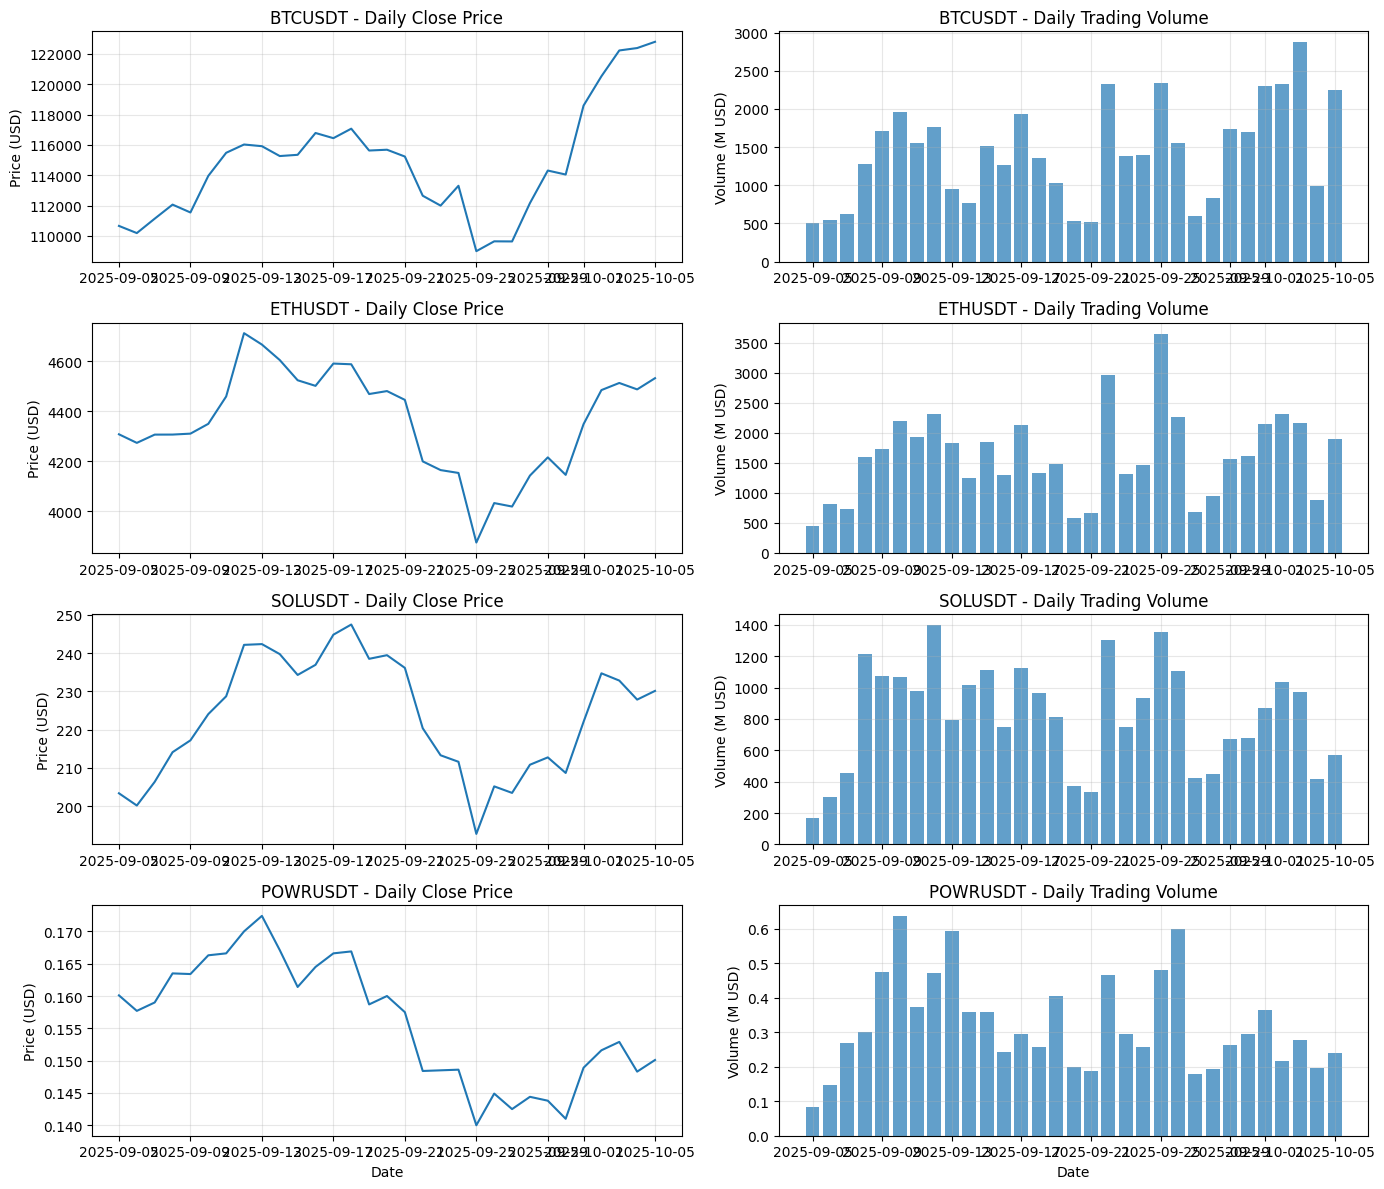


✓ Visualisation complete - Notice liquidity differences across symbols


In [7]:
## Visualise

import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(SYMBOLS), 2, figsize=(14, 3*len(SYMBOLS)))

for idx, symbol in enumerate(SYMBOLS):
    symbol_dir = DATA_DIR / symbol
    if not symbol_dir.exists():
        continue

    daily_files = sorted(symbol_dir.glob("*.parquet"))
    if not daily_files:
        continue

    dfs = [pd.read_parquet(f) for f in daily_files]
    df = pd.concat(dfs, ignore_index=True)
    df_sorted = df.sort_values('timestamp').set_index('timestamp')

    # Daily aggregation
    daily_close = df_sorted['price'].resample('D').last()
    daily_volume = df_sorted['dollar_volume'].resample('D').sum()

    # Price chart
    axes[idx, 0].plot(daily_close.index, daily_close.values, linewidth=1.5)
    axes[idx, 0].set_ylabel('Price (USD)')
    axes[idx, 0].set_title(f'{symbol} - Daily Close Price')
    axes[idx, 0].grid(alpha=0.3)

    # Volume chart
    axes[idx, 1].bar(daily_volume.index, daily_volume.values/1e6, alpha=0.7)
    axes[idx, 1].set_ylabel('Volume (M USD)')
    axes[idx, 1].set_title(f'{symbol} - Daily Trading Volume')
    axes[idx, 1].grid(alpha=0.3)

    if idx == len(SYMBOLS) - 1:
        axes[idx, 0].set_xlabel('Date')
        axes[idx, 1].set_xlabel('Date')

plt.tight_layout()
plt.show()

print("\n✓ Visualisation complete - Notice liquidity differences across symbols")

In [8]:
# Next Steps
"""
Transform this tick data into information-driven bars:
- Dollar bars
- Volume bars
- Tick imbalance bars

---
Author: James Eggleston
Date: October 2025
"""

'\nTransform this tick data into information-driven bars:\n- Dollar bars\n- Volume bars\n- Tick imbalance bars\n\n---\nAuthor: James Eggleston\nDate: October 2025\n'